- [About the instance](https://aws.amazon.com/marketplace/pp/B07T8STKZR?ref_=aws-mp-console-subscription-detail)
- [User Manual](http://dfk66cqpwr4ko.cloudfront.net/user_manual_en_v1_20.pdf)

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle

import pyqubo

In [322]:
from io import BytesIO
import json
from urllib.parse import urlunsplit, urlencode

import dimod
import scipy.sparse as sp
from scipy.io import mmwrite

class SBMSampler(dimod.Sampler, dimod.Initialized):
    parameters = None
    properties = None

    SCHEME = 'http'
    PATH = 'solver/ising'
    HTTP_HEADERS = {'Content-Type': 'application/octet-stream'}

    def __init__(self, host, port=8000):
        self.host = host
        self.port = port
        self.parameters = {
            'steps': [],
            'loops': [],
            'timeout': [],
            'maxwait': [],
            'target': [],
            'prefer': ['speed', 'auto'],
            'stats': ['none', 'summary', 'full'],
            'dt': [],
            'C': []
        }
        self.properties = {}

    def sample(self, bqm, steps=0, loops=1, timeout=None, maxwait=None, target=None, prefer='auto', stats=None, dt=1.0, C=0):
        biases, offset = bqm.to_qubo()
        keys = list(bqm.variables)
        key2idx = {key:idx for idx, key in enumerate(keys)}
        n_vars = len(keys)

        mat = sp.dok_matrix((n_vars, n_vars))
        for (key1, key2), bias in biases.items():
            row, col = key2idx[key1], key2idx[key2]
            mat[row, col] = bias
            if row != col:
                mat[col, row] = bias

        buff = BytesIO()
        mmwrite(buff, mat, symmetry='symmetric')
        buff.seek(0)
        req_body = buff.read()
        mmwrite('test', mat, symmetry='symmetric')

        query = urlencode(
            self._delete_if_none(
                dict(steps=steps, loops=loops, timeout=timeout, maxwait=maxwait, target=target, prefer=prefer, stats=stats, dt=dt, C=C)
            )
        )
        url = f'{self.SCHEME}://{self.host}:{self.port}/{self.PATH}?{query}'
        req = request.Request(url, req_body, self.HTTP_HEADERS)

        with request.urlopen(req) as res_:
            res = json.loads(res_.read())

        samples = np.array([res.pop('result')])
        energy = res.pop('value') + bqm.offset

        return dimod.SampleSet.from_samples(
            (samples, keys),
            energy=energy,
            info=res,
            vartype=dimod.SPIN
        )

    def _delete_if_none(self, d):
        return {k:v for k, v in d.items() if v != None}

In [317]:
list(bqm.variables)

['x[0][0][2]',
 'x[1][0][2]',
 'x[2][0][1]',
 'x[0][0][1]',
 'x[2][0][0]',
 'x[2][0][2]',
 'x[1][0][0]',
 'x[1][0][1]',
 'x[0][0][0]']

In [331]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_10.pkl')

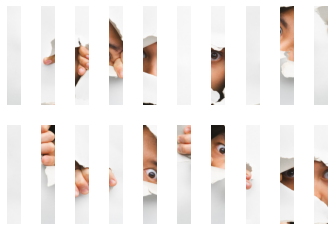

In [332]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [333]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()


print(sim_x(data.images[0], data.images[1]))
print(sim_y(data.images[0], data.images[1]))

20
0


In [334]:
def build_model(data, c=1):
    x = pyqubo.Array.create('x', shape=(data.size, data.rows, data.cols), vartype='BINARY')

    cost = 0
    sim = np.zeros((2, data.size, data.size))
    for a in range(data.size):
        for b in range(data.size):
            if a == b:
                continue
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        s = sim_y(data.images[a], data.images[b])
                        if s != 0:
                            cost -= s*x[a, row, col]*x[b, row + 1, col]
                            sim[0, a, b] = s
                    if col < data.cols - 1:
                        s = sim_x(data.images[a], data.images[b])
                        if s != 0:
                            cost -= s*x[a, row, col]*x[b, row, col + 1]
                            sim[1, a, b] = s

    constraint_coeff = c*(sim[0].max() + sim[1].max())
    for a in range(data.size):
        cost += constraint_coeff*pyqubo.Constraint((np.sum(x[a]) - 1)**2, f'img_{a}')
    for row in range(data.rows):
        for col in range(data.cols):
            cost += constraint_coeff*pyqubo.Constraint((np.sum(x[:, row, col]) - 1)**2, f'pos_{row}_{col}')

    return cost.compile(), x

model, x = build_model(data)

In [346]:
SBM_HOST = '13.231.20.10'

model, x = build_model(data, c=10000)
bqm = model.to_bqm()
sampler = SBMSampler(SBM_HOST)
%time sampleset = sampler.sample(bqm, loops=100000)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

CPU times: user 843 ms, sys: 16.2 ms, total: 859 ms
Wall time: 1min 1s


In [347]:
def is_feasible(sample):
    return all(v[0] for v in sample.constraints().values())

def show_solution(sample, data, x):
    values = np.vectorize(lambda x: sample[x.label])(x)
    pos = np.array(np.where(values == 1)).T
    images = [
        data.images[p[0]]
        for p in sorted(pos, key=lambda x: [x[1], x[2]])
    ]
    show(images[:data.size], data.rows, data.cols)

print(f'cost: {best_sample.energy}')
assert is_feasible(best_sample)
print(best_sample.sample)
show_solution(best_sample.sample, data, x)

cost: 209279652.0


AssertionError: 

CPU times: user 7.22 s, sys: 184 ms, total: 7.41 s
Wall time: 8.39 s
cost: -2488.0
{'x[0][1][0]': 0, 'x[0][0][2]': 0, 'x[0][1][1]': 0, 'x[1][0][0]': 0, 'x[12][1][5]': 0, 'x[3][0][7]': 0, 'x[4][1][1]': 0, 'x[18][1][2]': 0, 'x[2][1][6]': 0, 'x[12][1][4]': 0, 'x[10][1][0]': 0, 'x[19][1][7]': 0, 'x[11][0][1]': 0, 'x[14][1][5]': 0, 'x[12][0][6]': 0, 'x[0][0][8]': 0, 'x[2][1][5]': 0, 'x[14][0][4]': 0, 'x[1][1][5]': 0, 'x[10][1][6]': 0, 'x[0][0][9]': 0, 'x[16][1][4]': 0, 'x[15][1][5]': 0, 'x[15][1][1]': 0, 'x[10][0][3]': 0, 'x[2][0][4]': 0, 'x[12][1][9]': 0, 'x[0][0][5]': 0, 'x[9][1][2]': 0, 'x[19][0][8]': 0, 'x[17][0][7]': 1, 'x[4][1][3]': 0, 'x[16][1][1]': 0, 'x[0][1][6]': 0, 'x[5][0][4]': 0, 'x[19][1][8]': 0, 'x[10][1][7]': 1, 'x[1][0][5]': 0, 'x[13][1][8]': 0, 'x[1][1][1]': 0, 'x[15][0][9]': 0, 'x[2][1][0]': 0, 'x[11][0][2]': 0, 'x[0][1][2]': 0, 'x[2][0][2]': 0, 'x[5][0][8]': 1, 'x[10][0][6]': 0, 'x[19][0][9]': 0, 'x[0][1][5]': 0, 'x[16][0][4]': 0, 'x[8][0][1]': 0, 'x[11][1][7]': 0, 'x[12

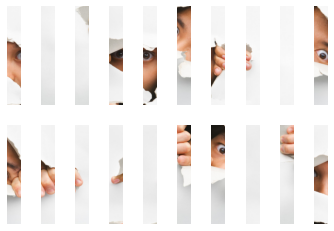

In [351]:
import neal

sampler = neal.SimulatedAnnealingSampler()
%time sampleset = sampler.sample(bqm, num_reads=1000)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

print(f'cost: {best_sample.energy}')
assert is_feasible(best_sample)
print(best_sample.sample)
show_solution(best_sample.sample, data, x)

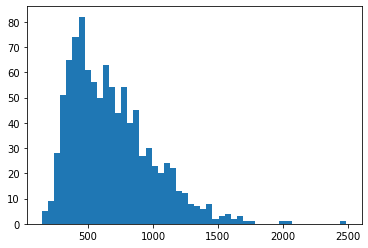

In [352]:
import matplotlib.pyplot as plt

_ = plt.hist([-sample.energy for sample in decoded_samples], bins=50)